
This code implements an emotion classifier using the DEAP emotional dataset. The process is organized into three main steps:

* Feature extraction: Performed using Wavelet Scattering with the Kymatio library.
* Dimensionality reduction: Achieved through Principal Component Analysis (PCA).
* Classification: Conducted with a Multilayer Perceptron (MLP).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Import librarys

Kymatio implements the Wavelet Scattering (WS) algorithm, providing a powerful tool for extracting robust features from signals such as EEG data.

In [ ]:
#WS
!pip install kymatio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 9.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import scipy.io as iso
import matplotlib.pyplot as plt
import torch
from kymatio.torch import Scattering1D
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
import torch.nn as nn
import torch.nn.functional as F

#Functions

The EEG data is structured as a matrix with dimensions `samples x channels x data points`. To augment the dataset for training the classifier, we reorganize it into a matrix of dimensions `(samples * channels) x data points`. After reordering, the data is normalized using the ` MinMaxScaler()` function from the scikit-learn library.

In [ ]:
def preprocess_data(x, y, dim):
  '''
      Parameters:
    ----------
    x : numpy.ndarray
        EEG data matrix with original dimensions (participants, videos, channels, samples).
    y : numpy.ndarray
        Label matrix corresponding to `x`, with original dimensions (participants, videos, features).
    dim : int
        Index of the label dimension to extract and process.

    Returns:
    -------
    x : numpy.ndarray
        Normalized and restructured EEG data with adjusted dimensions for analysis.
    y : numpy.ndarray
        Processed binary labels (0 or 1) corresponding to the normalized EEG data.
    '''
    #Concatenate all the participants and videos
    x = x.reshape(x.shape[0]*x.shape[1], x.shape[2], -1) #(32*40, 32, 8064)
    print(x.shape)
    y = y.reshape(y.shape[0]*y.shape[1], -1) #(32*40, 4)
    print(y.shape)
    #Normalization
    x = x.reshape(x.shape[0]*x.shape[1], -1) #every channel will be a feature
    x = x.transpose() #transpose for the normalization
    print(x.shape)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(x)
    x = scaler.transform(x)
    x = x.transpose() #Return to initial dimensions to work with WS
    print(x.shape)
    #Adjust the number of labels to the number of features
    print(y.shape)
    len_y = len(y)
    y_ = []
    for i in range(len_y):
      for j in range(32):
        y_.append(y[i])
    y = np.array(y_)
    y = np.where(y > 5, 1, 0)
    print(y.shape)
    #See labels distribution
    len_train = len(y)
    count_1 = 0
    count_0 = 0
    for i in range(len_train):
      if(y[i, 1] == 1):
        count_0+=1
      else:
        count_1+=1
    print('number of 0:', count_0, 'number of 1:', count_1)

    y = y[:, dim]
    y = y.reshape(-1, 1) #reshape to (samples, 1)
    return x, y

This function receives the model and a data loader to validate its performance on a specific data partition. It returns the confusion matrix and the average loss of the model. This function is used at the end of each epoch during training to evaluate the model's performance.

In [ ]:
#Validation
def dataset_validation(loader, model, criterion, conf_m):
  '''
    Validates a dataset using the provided model and loss criterion.

    Parameters:
    ----------
    loader : torch.utils.data.DataLoader
        DataLoader object that provides the dataset to validate in batches.
    model : torch.nn.Module
        Trained neural network model used for predictions.
    criterion : torch.nn.Module
        Loss function used to calculate the model's performance.
    conf_m : int
        Flag to determine whether to calculate and return the confusion matrix.
        If 1, the confusion matrix is computed; otherwise, it is not.

    Returns:
    -------
    acc : float
        Accuracy of the model on the validation dataset, as a percentage.
    avg_loss : float
        Average loss across the entire validation dataset.
    conf_matrix : numpy.ndarray (optional)
        Confusion matrix showing the distribution of predictions vs actual labels
        if `conf_m` is set to 1.
  '''
  model.eval() #model in mode evaluation
  class_labels = []
  class_preds = []
  #loss
  running_loss = 0.0
  n_samples = 0
  #Confusion matrix
  all_preds = []
  all_labels = []

  with torch.no_grad():
        n_correct = 0
        n_samples = 0
        for i,(images, labels) in enumerate(loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            # max returns (value ,index)
            predicted = outputs.round()
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            #loss
            running_loss += loss.item() * images.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        acc = 100.0 * n_correct /  len(loader.dataset)
        avg_loss = running_loss /  len(loader.dataset)  # Pérdida media

  model.train()  #Train mode
  #Confusion matrix
  all_preds = np.array(all_preds)
  all_labels = np.array(all_labels)

  if conf_m == 1:
      conf_matrix = confusion_matrix(all_labels, all_preds)
      return  acc, avg_loss, conf_matrix
  else:
        return acc, avg_loss

This function trains a neural network model (`NN_classifier`) using a training dataset and
evaluates its performance on a test dataset. It uses the Adam optimizer and binary cross-entropy
loss function. After each epoch, it computes accuracy and loss for both the training and test datasets.  
The function also generates and saves plots of accuracy and loss curves and returns the confusion
matrix of the best-performing epoch on the test dataset.

In [ ]:
#Train the network for one participant and return the confusion matrix and
#The best average accuracy and the confusion matrix
def trainer(train_dataset, test_dataset, path_img, participant):
  '''
  Trains a neural network model on the given datasets and evaluates its performance.
    Parameters:
    ----------
    train_dataset : torch.utils.data.Dataset
        Dataset used for training the neural network.
    test_dataset : torch.utils.data.Dataset
        Dataset used for testing the neural network.
    path_img : str
        Path where the performance graphs will be saved.
    participant : str
        Identifier for the participant, used to label output files and results.

    Returns:
    -------
    final_cm : numpy.ndarray
        Confusion matrix corresponding to the epoch with the highest test accuracy.
    max_accuracy_test : float
        Maximum accuracy achieved on the test dataset during training.
    Train_acc : list[float]
        List of training accuracies for each epoch.
    Train_loss : list[float]
        List of training losses for each epoch.
    Test_acc : list[float]
        List of test accuracies for each epoch.
    Test_loss : list[float]
        List of test losses for each epoch.
    '''
    #Hyperparameters
    batch_size = 128
    #Backward
    learning_rate = 0.001
    weight_decay = 0.0 #Regularization L2
    num_epochs = 30

    #Create NN classifier
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = NN_classifier().to(device)

    #DataLoader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                              shuffle=True, num_workers=2)

    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)

    #Loss
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = weight_decay)

    #Train the model
    iter_print = 100
    running_loss = 0.0
    running_correct = 0.0
    #Evaluation curves
    Train_acc = []
    Train_loss = []
    Test_acc = []
    Test_loss = []
    #Confusion matrix
    CF = []

    n_total_steps = len(train_loader) #sample number / batch size --> 41948/128
    for epoch in range(num_epochs):
        for i, (signals, labels) in enumerate(train_loader):
            #signals.reshape(128, 1, 32, 384)
            signals = signals.to(device)
            labels = labels.to(torch.float32)
            labels = labels.to(device)
            # Forward pass
            outputs = model(signals)
            #loss = criterion(m(outputs), labels)
            loss = criterion(outputs, labels)
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        #Show results
        train_acc, train_avrg_loss = dataset_validation(train_loader, model, criterion, conf_m = 0)
        test_acc, test_avrg_loss, cm = dataset_validation(test_loader, model, criterion, conf_m = 1)
        print (f'Epoch [{epoch+1}/{num_epochs}],  Accuracy on the train dataset: {train_acc}, Accuracy on the test dataset: {test_acc}')
        print (f'Epoch [{epoch+1}/{num_epochs}],  Loss on the train dataset: {train_avrg_loss}, Loss on the test dataset: {test_avrg_loss}')
        #Save results
        Train_acc.append(train_acc)
        Train_loss.append(train_avrg_loss)
        Test_acc.append(test_acc)
        Test_loss.append(test_avrg_loss)
        CF.append(cm)

    print('Finished Training')

    max_accuracy_test = max(Test_acc)
    max_accuracy_test_index = Test_acc.index(max_accuracy_test)
    print('max accuracy ', participant,  max_accuracy_test)
    #Return the confusion matrix of the best accuracy of the algorithm
    final_cm = CF[max_accuracy_test_index]
    #Graphs
    plt.figure(figsize=(12, 6))
    #Acc
    plt.subplot(1, 2, 1)
    plt.plot(Train_acc, label='Train Accuracy')
    plt.plot(Test_acc, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train vs Test Accuracy')
    plt.legend()
    #Loss
    plt.subplot(1, 2, 2)
    plt.plot(Train_loss, label='Train Loss')
    plt.plot(Test_loss, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train vs Test Loss')
    plt.legend()
    #Save graph
    plt.savefig( path_img + participant + '.png' )
    plt.show()
    plt.close()

    return final_cm, max_accuracy_test, Train_acc, Train_loss, Test_acc, Test_loss

This function recieve a confusion matrix and compute accuracy, precision, recall  and f1-score.

In [ ]:
import numpy as np

def compute_metrics(confusion_matrix):
  '''
  Computes classification metrics (accuracy, precision, recall, and F1-score)
    based on a given confusion matrix.

    Parameters:
    ----------
    confusion_matrix : numpy.ndarray
        A square confusion matrix of shape (C, C), where C is the number of classes.
        Rows represent the true class, and columns represent the predicted class.

    Returns:
    -------
    metrics : numpy.ndarray
        A 1D array containing the following metrics (in order):
        - accuracy_macro : float
            The overall accuracy, computed as the mean of accuracies across all classes.
        - precision_macro : float
            The macro-averaged precision across all classes.
        - recall_macro : float
            The macro-averaged recall across all classes.
        - f1_score_macro : float
            The macro-averaged F1-score across all classes.
  '''

    confusion_matrix = np.array(confusion_matrix)
    TP = np.diag(confusion_matrix)
    FP = np.sum(confusion_matrix, axis=0) - TP
    FN = np.sum(confusion_matrix, axis=1) - TP
    TN = np.sum(confusion_matrix) - (TP + FP + FN)

    # Prevent errors caused by element/0 divisions
    with np.errstate(divide='ignore', invalid='ignore'):
        accuracy = (TP + TN) / (TP + TN + FP + FN)
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        f1_score = 2 * (precision * recall) / (precision + recall)

    # Means
    accuracy_macro = np.nanmean(accuracy)
    precision_macro = np.nanmean(precision)
    recall_macro = np.nanmean(recall)
    f1_score_macro = np.nanmean(f1_score)

    # Results
    metrics = np.array([accuracy_macro, precision_macro, recall_macro, f1_score_macro])

    return metrics

#Classes



`NN_classifier` class contains the architecture of the emotion classifier.

In [ ]:
#Classifier MLP
class NN_classifier(nn.Module):
    def __init__(self):
        super(NN_classifier, self).__init__()
        #Fully connected net
        self.fc1 = nn.Linear( 974, 475)
        self.dropout1 = nn.Dropout(p=0.5)
        self.bn1 = nn.BatchNorm1d(475)
        self.fc2 = nn.Linear(475, 1)  # Output for binary classification task

    def forward(self, x):
        #Fully connected net
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.bn1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        #Normalization with softmax layer
        x = torch.sigmoid(x)
        return x



The `Feature_extract` class is used to extract Wavelet Scattering (WS) features and perform Principal Component Analysis (PCA). WS features are computed in batches using the GPU for efficiency, and the results are then transferred to the CPU to perform PCA.

In [ ]:
#Extract WS and PCA
class Feature_extract(nn.Module):
    """
    A PyTorch module for feature extraction using Wavelet Scattering (WS)
    and Principal Component Analysis (PCA).

    Methods:
    --------
    ws(x, batch_size=1280):
        Applies the Wavelet Scattering transform to the input data in batches.
    fit_pca(x):
        Fits the PCA model on the input data and reduces dimensionality.
    transform_pca(x):
        Transforms the input data using the pre-fitted PCA model.
    """
    def __init__(self, T, J, Q, device):
        """
              Parameters:
        ----------
        T : int
            The temporal length of the input signals.
        J : int
            The scale of the scattering transform.
        Q : int
            The number of wavelets per octave in the scattering transform.
        device : str or torch.device
            The device where computations will be performed ('cpu' or 'cuda').
        """
        super(Feature_extract, self).__init__()
        self.device = device
        #WS
        self.scattering = Scattering1D(J=J, shape=(T,), Q=Q).to(self.device)
        #PCA
        self.pca = PCA(n_components=974)

    def ws(self, x, batch_size = 1280):
        """
        Applies Wavelet Scattering (WS) to the input data.

        Parameters:
        ----------
        x : numpy.ndarray or torch.Tensor
            Input data of shape (samples, T), where T is the temporal length of the signals.
        batch_size : int, optional
            The number of samples to process in each batch. Default is 1280.

        Returns:
        -------
        x : torch.Tensor
            The transformed data after applying WS, concatenated across all batches.
        """
            x = torch.tensor(x, dtype=torch.float32)
            #Separate x in batches
            batches = torch.split(x, batch_size)
            #Apply scattering to each batch
            results = []
            for batch in batches:
                batch = torch.tensor(batch, dtype=torch.float32).to(self.device) #bring batch to cpu
                result = self.scattering(batch) #ws transform
                result = result.cpu() #Return tensor to cpu
                results.append(result)
                del batch  # Free momory from the GPU
                del result
                torch.cuda.empty_cache()
            # Concatenate results
            x = torch.cat(results, dim=0)
            return x

    def fit_pca(self, x):
        """
        Fits PCA to the input data and reduces its dimensionality.

        Parameters:
        ----------
        x : numpy.ndarray or torch.Tensor
            Input data of shape (samples, features).

        Returns:
        -------
        x : torch.Tensor
            Data transformed by PCA, reduced to 974 components.
        """
        x = x.reshape(x.shape[0], -1)
        #pca
        print('Computing PCA...')
        x = self.pca.fit_transform(x)
        #convert to tensor
        x = torch.tensor(x, dtype = torch.float32)
        #Sum of the explained variance ratio
        explained_variance_sum = sum(self.pca.explained_variance_ratio_[:974])
        print(f"Suma de la varianza explicada por las primeras {974} componentes: {explained_variance_sum}")
        return x

    def transform_pca(self, x):
        """
        Transforms the input data using the fitted PCA model.

        Parameters:
        ----------
        x : numpy.ndarray or torch.Tensor
            Input data of shape (samples, features).

        Returns:
        -------
        x : torch.Tensor
            Data transformed by the fitted PCA model, reduced to 974 components.
        """
        x = x.reshape(x.shape[0], -1)
        #pca
        x = self.pca.transform(x)
        #convert to tensor
        x = torch.tensor(x, dtype = torch.float32)
        return x



`CustomDataset` defines how the data is prepared and structured to be fed into data loaders.

In [ ]:
class CustomDataset(Dataset):
    def __init__(self):
      """
    Attributes:
    ----------
    x : list
        A list of input features (e.g., signals, images, or other data).
    y : list
        A list of corresponding labels for the input features.

    Methods:
    -------
    __len__():
        Returns the total number of samples in the dataset.
    __getitem__(idx):
        Retrieves the input features and labels for a given index.
    """
        self.x =[]
        self.y =[]

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        sample = self.x[idx], self.y[idx]
        return sample

#Main code

We load and preprocess EEG data from 32 participants, extract Wavelet Scattering (WS) features, and apply Principal Component Analysis (PCA). The MLP classifier is trained using 5-fold cross-validation, achieving a mean classification accuracy of up to 95% for two classes: high valence and low valence.

s01.mat ready
s02.mat ready
s03.mat ready
s04.mat ready
s05.mat ready
s06.mat ready
s07.mat ready
s08.mat ready
s09.mat ready
s10.mat ready
s11.mat ready
s12.mat ready
s13.mat ready
s14.mat ready
s15.mat ready
s16.mat ready
s17.mat ready
s18.mat ready
s19.mat ready
s20.mat ready
s21.mat ready
s22.mat ready
s23.mat ready
s24.mat ready
s25.mat ready
s26.mat ready
s27.mat ready
s28.mat ready
s29.mat ready
s30.mat ready
s31.mat ready
s32.mat ready
(1280, 32, 8064)
(1280, 4)
(8064, 40960)
(40960, 8064)
(1280, 4)
(40960, 4)
number of 0: 17024 number of 1: 23936
x: (40960, 8064) y (40960, 1)
float32 float32
Computing WS...


<ipython-input-7-56b005265562>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = torch.tensor(batch, dtype=torch.float32).to(self.device) #bring batch to cpu


Computing PCA...
Suma de la varianza explicada por las primeras 974 componentes: 0.9964912780747327


<ipython-input-8-ec4a6d7c7c39>:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset.x = torch.tensor(train_dataset.x, dtype=torch.float32)
<ipython-input-8-ec4a6d7c7c39>:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset.x = torch.tensor(test_dataset.x, dtype=torch.float32)


Epoch [1/30],  Accuracy on the train dataset: 78.40576171875, Accuracy on the test dataset: 76.3427734375
Epoch [1/30],  Loss on the train dataset: 0.477836997481063, Loss on the test dataset: 0.508229321334511
Epoch [2/30],  Accuracy on the train dataset: 83.9324951171875, Accuracy on the test dataset: 80.72509765625
Epoch [2/30],  Loss on the train dataset: 0.3832236441085115, Loss on the test dataset: 0.4317021656315774
Epoch [3/30],  Accuracy on the train dataset: 90.1092529296875, Accuracy on the test dataset: 85.92529296875
Epoch [3/30],  Loss on the train dataset: 0.2766664244700223, Loss on the test dataset: 0.34216670284513384
Epoch [4/30],  Accuracy on the train dataset: 93.609619140625, Accuracy on the test dataset: 88.97705078125
Epoch [4/30],  Loss on the train dataset: 0.1972107426263392, Loss on the test dataset: 0.2839460300747305
Epoch [5/30],  Accuracy on the train dataset: 95.977783203125, Accuracy on the test dataset: 90.78369140625
Epoch [5/30],  Loss on the train 

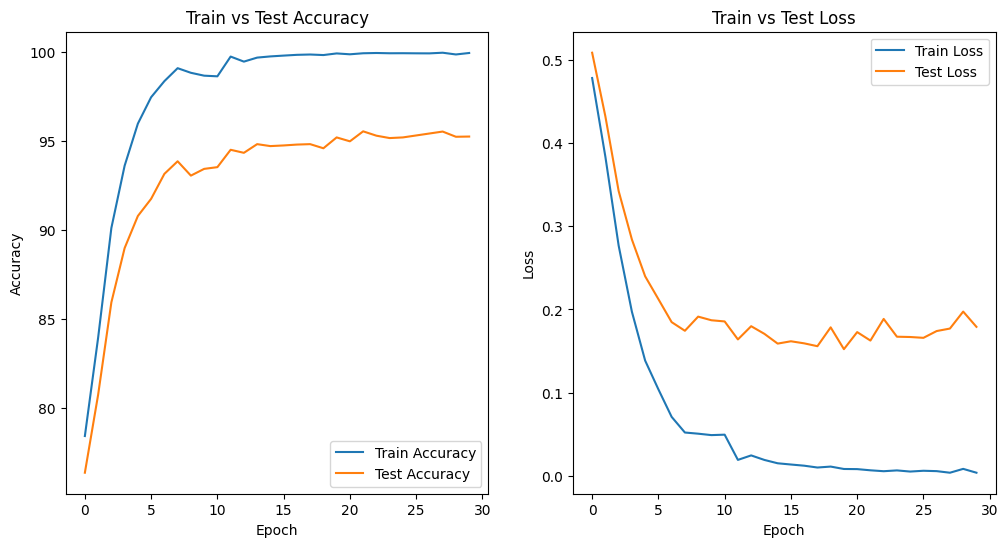

Accuracy: 95.54443359375
[[3475  198]
 [ 167 4352]]
Computing PCA...
Suma de la varianza explicada por las primeras 974 componentes: 0.9965044186618698


<ipython-input-8-ec4a6d7c7c39>:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset.x = torch.tensor(train_dataset.x, dtype=torch.float32)
<ipython-input-8-ec4a6d7c7c39>:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset.x = torch.tensor(test_dataset.x, dtype=torch.float32)


Epoch [1/30],  Accuracy on the train dataset: 75.5462646484375, Accuracy on the test dataset: 73.10791015625
Epoch [1/30],  Loss on the train dataset: 0.5040742588462308, Loss on the test dataset: 0.5407268474809825
Epoch [2/30],  Accuracy on the train dataset: 83.441162109375, Accuracy on the test dataset: 79.94384765625
Epoch [2/30],  Loss on the train dataset: 0.38888324389699847, Loss on the test dataset: 0.4418299784883857
Epoch [3/30],  Accuracy on the train dataset: 88.751220703125, Accuracy on the test dataset: 84.21630859375
Epoch [3/30],  Loss on the train dataset: 0.29154699749778956, Loss on the test dataset: 0.36736816144548357
Epoch [4/30],  Accuracy on the train dataset: 93.8446044921875, Accuracy on the test dataset: 88.51318359375
Epoch [4/30],  Loss on the train dataset: 0.20239868655335158, Loss on the test dataset: 0.28997982654254884
Epoch [5/30],  Accuracy on the train dataset: 95.5780029296875, Accuracy on the test dataset: 90.07568359375
Epoch [5/30],  Loss on t

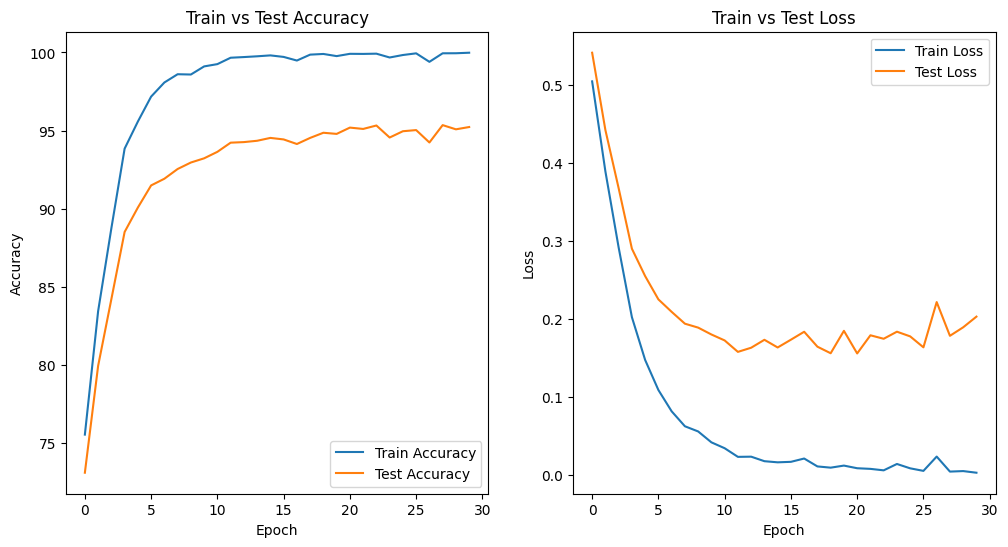

Accuracy: 95.34912109375
[[3480  193]
 [ 188 4331]]
Computing PCA...
Suma de la varianza explicada por las primeras 974 componentes: 0.9964359210082713


<ipython-input-8-ec4a6d7c7c39>:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset.x = torch.tensor(train_dataset.x, dtype=torch.float32)
<ipython-input-8-ec4a6d7c7c39>:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset.x = torch.tensor(test_dataset.x, dtype=torch.float32)


Epoch [1/30],  Accuracy on the train dataset: 76.6998291015625, Accuracy on the test dataset: 74.62158203125
Epoch [1/30],  Loss on the train dataset: 0.49002098431810737, Loss on the test dataset: 0.525521089322865
Epoch [2/30],  Accuracy on the train dataset: 82.672119140625, Accuracy on the test dataset: 79.13818359375
Epoch [2/30],  Loss on the train dataset: 0.3956480142660439, Loss on the test dataset: 0.4543293723836541
Epoch [3/30],  Accuracy on the train dataset: 89.947509765625, Accuracy on the test dataset: 85.4736328125
Epoch [3/30],  Loss on the train dataset: 0.27425921481335536, Loss on the test dataset: 0.3551035984419286
Epoch [4/30],  Accuracy on the train dataset: 92.315673828125, Accuracy on the test dataset: 86.962890625
Epoch [4/30],  Loss on the train dataset: 0.22051403421210125, Loss on the test dataset: 0.3138415028806776
Epoch [5/30],  Accuracy on the train dataset: 96.1822509765625, Accuracy on the test dataset: 91.0888671875
Epoch [5/30],  Loss on the train

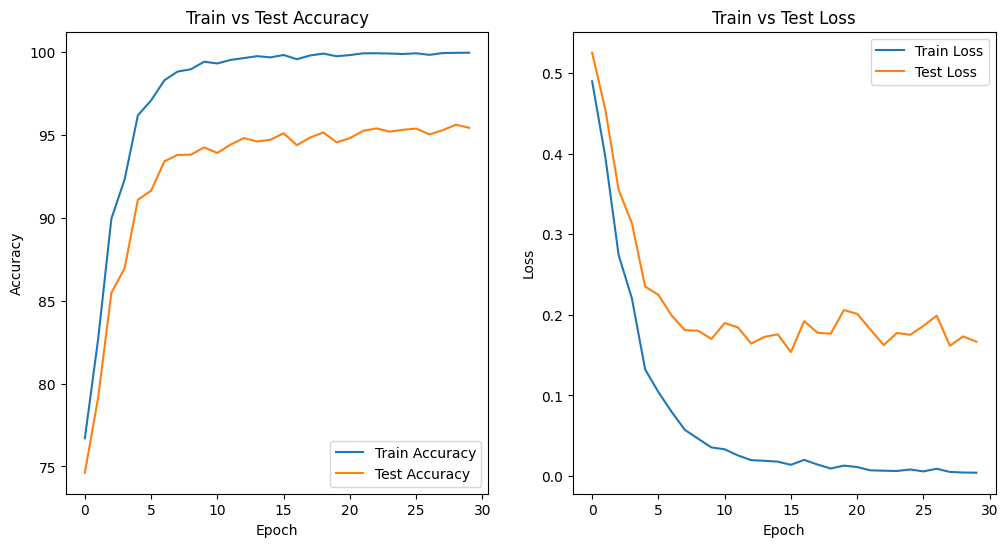

Accuracy: 95.61767578125
[[3450  224]
 [ 135 4383]]
Computing PCA...
Suma de la varianza explicada por las primeras 974 componentes: 0.9964667888353759


<ipython-input-8-ec4a6d7c7c39>:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset.x = torch.tensor(train_dataset.x, dtype=torch.float32)
<ipython-input-8-ec4a6d7c7c39>:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset.x = torch.tensor(test_dataset.x, dtype=torch.float32)


Epoch [1/30],  Accuracy on the train dataset: 77.0904541015625, Accuracy on the test dataset: 75.1708984375
Epoch [1/30],  Loss on the train dataset: 0.48478964262176305, Loss on the test dataset: 0.5165302352979779
Epoch [2/30],  Accuracy on the train dataset: 84.5001220703125, Accuracy on the test dataset: 81.38427734375
Epoch [2/30],  Loss on the train dataset: 0.3769639964448288, Loss on the test dataset: 0.4279876574873924
Epoch [3/30],  Accuracy on the train dataset: 87.5091552734375, Accuracy on the test dataset: 83.89892578125
Epoch [3/30],  Loss on the train dataset: 0.3038183287717402, Loss on the test dataset: 0.36955962353385985
Epoch [4/30],  Accuracy on the train dataset: 93.7530517578125, Accuracy on the test dataset: 89.27001953125
Epoch [4/30],  Loss on the train dataset: 0.20087279775179923, Loss on the test dataset: 0.2863164792070165
Epoch [5/30],  Accuracy on the train dataset: 95.880126953125, Accuracy on the test dataset: 90.2587890625
Epoch [5/30],  Loss on the 

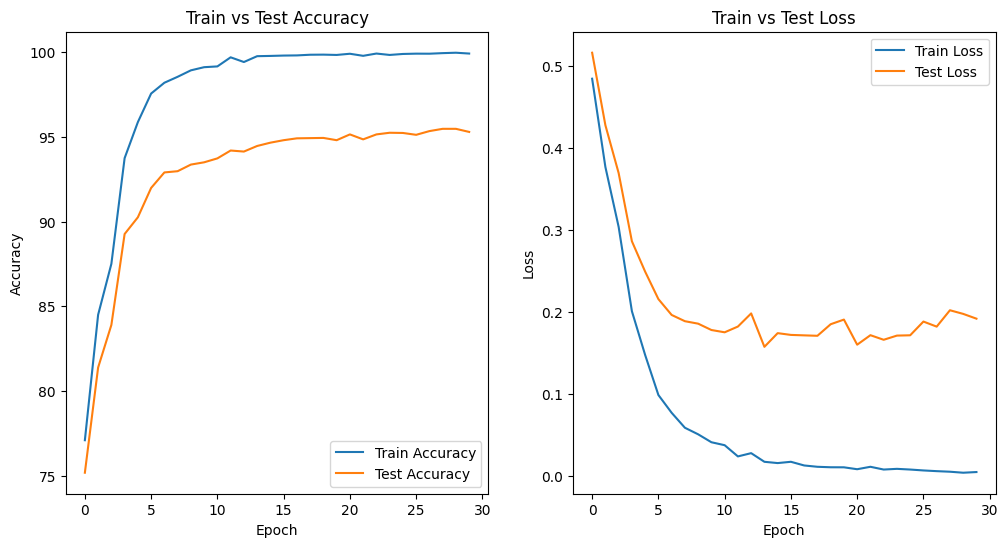

Accuracy: 95.4833984375
[[3478  196]
 [ 174 4344]]
Computing PCA...
Suma de la varianza explicada por las primeras 974 componentes: 0.996465022518564


<ipython-input-8-ec4a6d7c7c39>:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset.x = torch.tensor(train_dataset.x, dtype=torch.float32)
<ipython-input-8-ec4a6d7c7c39>:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset.x = torch.tensor(test_dataset.x, dtype=torch.float32)


Epoch [1/30],  Accuracy on the train dataset: 76.6815185546875, Accuracy on the test dataset: 72.79052734375
Epoch [1/30],  Loss on the train dataset: 0.49423289007972926, Loss on the test dataset: 0.5411562076769769
Epoch [2/30],  Accuracy on the train dataset: 83.5418701171875, Accuracy on the test dataset: 79.8583984375
Epoch [2/30],  Loss on the train dataset: 0.38889409718103707, Loss on the test dataset: 0.44656910211779177
Epoch [3/30],  Accuracy on the train dataset: 89.7308349609375, Accuracy on the test dataset: 84.8388671875
Epoch [3/30],  Loss on the train dataset: 0.277082176937256, Loss on the test dataset: 0.35420528426766396
Epoch [4/30],  Accuracy on the train dataset: 93.218994140625, Accuracy on the test dataset: 88.0859375
Epoch [4/30],  Loss on the train dataset: 0.19604439206887037, Loss on the test dataset: 0.29413115250645205
Epoch [5/30],  Accuracy on the train dataset: 94.9554443359375, Accuracy on the test dataset: 89.78271484375
Epoch [5/30],  Loss on the tr

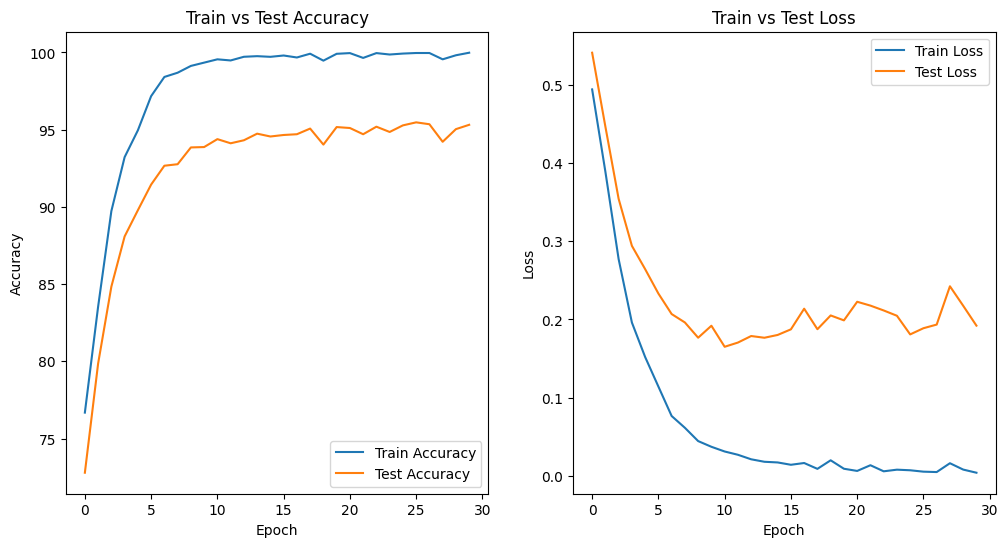

Accuracy: 95.47119140625
[[3461  213]
 [ 158 4360]]
Puntuaciones de validación cruzada: [95.54443359375, 95.34912109375, 95.61767578125, 95.4833984375, 95.47119140625]
Exactitud media: 95.4932


In [ ]:
import warnings

# Ignore warnings from dataloader and fork
warnings.filterwarnings("ignore", category=UserWarning, module="torch.utils.data.dataloader")
warnings.filterwarnings("ignore", category=RuntimeWarning, module="multiprocessing.popen_fork")

path = '/content/drive/MyDrive/Proyect_ws/data/'
path_img = '/content/drive/MyDrive/Proyect_ws/images_results/'
path_stats = '/content/drive/MyDrive/Proyect_ws/all_stats/'

dim = 0
start = True

x = []
y = []

list_participants = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]

#Load data
for p in list_participants:
  participant = "s"+f"{p:02}"+".mat"
  data_file = iso.loadmat(path + participant)
  #data
  x_p= np.array(data_file['data'], dtype='float32')
  x_p= x_p[:, 0:32, :]
  #labels
  y_p= np.array(data_file['labels'], dtype='int64')

  x.append(x_p)
  y.append(y_p)
  print(participant, 'ready')

x = np.array(x)
y = np.array(y)

#Conctenate, normalize and reorder data
x, y = preprocess_data(x, y, dim = dim)
y = np.array(y, dtype='float32')
print('x:', x.shape, 'y', y.shape)
print(x.dtype, y.dtype)


###### WS extraction
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#PCA and WS extractor
f_extract = Feature_extract(T = x.shape[1], J = 6, Q = 100, device = device).to(device)
#Compute WS
print('Computing WS...')
Sx = f_extract.ws(x)

# Crear el objeto StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state = True, shuffle = True)

# Almacenar las puntuaciones
scores = []
CM = []
acc_result = []
acc_result_test = []
loss_result = []
loss_result_test = []

#Define datasets
train_dataset = CustomDataset()
test_dataset = CustomDataset()

# Iterar sobre cada pliegue
for train_index, test_index in skf.split(Sx, y):
    #Split data
    train_dataset.x, test_dataset.x = Sx[train_index], Sx[test_index]
    train_dataset.y, test_dataset.y = y[train_index], y[test_index]
    #Compute PCA
    train_dataset.x = f_extract.fit_pca(train_dataset.x)
    test_dataset.x = f_extract.transform_pca(test_dataset.x)
    train_dataset.x = torch.tensor(train_dataset.x, dtype=torch.float32)
    test_dataset.x = torch.tensor(test_dataset.x, dtype=torch.float32)

    # Train clasifier, save accuracy and loss curves
    final_cm, max_accuracy_test, Train_acc, Train_loss, Test_acc, Test_loss = trainer(train_dataset, test_dataset, path_img, participant)
    print("Accuracy:", max_accuracy_test)
    print(final_cm)
    #Max score
    scores.append(max_accuracy_test)
    #Confusion matrix
    CM.append(final_cm)
    #Train/loss functions
    acc_result.append(Train_acc)
    acc_result_test.append(Test_acc)
    loss_result.append(Train_loss)
    loss_result_test.append(Test_loss)

#Show punctuation
print(f'Puntuaciones de validación cruzada: {scores}')
print(f'Exactitud media: {np.mean(scores):.4f}')

np.save(path_stats + 'acc_all_participants_si_3.npy', scores)
np.save(path_stats + 'CM_all_participants_si_3.npy', CM)
np.save(path_stats + 'acc_result_si_3.npy', acc_result)
np.save(path_stats + 'acc_result_test_si_3.npy', acc_result_test)
np.save(path_stats + 'loss_result_si_3.npy', loss_result)
np.save(path_stats + 'loss_result_test_si_3.npy', loss_result_test)